## <font color='limegreen'>HIRING DEMAND FORECASTING</font>
### <font color='limegreen'>III - DEEP LEARNING MODELS</font>

In [1]:
# Python Language Version
from platform import python_version
print('The python version used in this jupyter notebook:', python_version())

The python version used in this jupyter notebook: 3.11.5


### 1. LOAD PACKAGES

#### Import packages

In [2]:
%%capture output
!pip install -q -r requirements.txt

In [3]:
from utils import *

### 2. LOAD DATA

In [4]:
# Load original
df_origin = pd.read_csv('../data/clean_data.csv')

In [5]:
# Original copy
df = df_origin.copy()

### 3. UNDERSTANDE AND PROCESS DATA

In [6]:
df.head()

,data,contratacoes
0,2020-01-01,241.0
1,2020-01-02,175.0
2,2020-01-03,235.0
3,2020-01-04,117.0
4,2020-01-05,124.0


In [7]:
df.shape

(1886, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   data          1886 non-null   object 
 1   contratacoes  1886 non-null   float64
dtypes: float64(1), object(1)
memory usage: 29.6+ KB


In [9]:
# Time series period
print(f"Time series period: {df['data'].min()} to {df['data'].max()}")

Time series period: 2020-01-01 to 2025-02-28


In [10]:
# Convert 'data' variable to datetime and index
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df = df.set_index('data').asfreq('D')

### 4. SUMMARY OF DATA CARACTERITICS

A série temporal univariada abrange o período de 01/01/2020 a 28/02/2025, totalizando 1.886 registros. O conjunto de dados contém as variáveis 'data' (índice datetime) e 'contratacoes'. A série apresenta uma distribuição não normal, com assimetria à direita, padrões não lineares, e a presença de outliers. Apesar dessas características, a série é estacionária, homocedástica, exibindo sazonalidade, uma tendência de crescimento e correlação significativa.

### 5. DEEP LEARNING MODELS

#### 5.1. DATA PREPARATION

In [11]:
# Time series
series = df['contratacoes'].values.reshape(-1, 1)

# Normalization
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# Function to create windows
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Hyperparameter
look_back = 30

# Create windows
X, y = create_dataset(series_scaled, look_back)

# Adjust to 3D
# (batch size, sequence length, features)
X = X.reshape((X.shape[0], look_back, 1))

# Split train (70%), validation (15%), test (15%)
total = X.shape[0]
train = int(total * 0.7)
val = int(total * 0.85)

X_train, y_train = X[:train], y[:train]
X_val, y_val = X[train:val], y[train:val]
X_test, y_test = X[val:], y[val:]

#### 5.2. GRU MODEL

In [12]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

Device used: cpu


In [13]:
# Convert NumPy data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [14]:
# Model definition
class ImprovedGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2, dropout=0.2):  
        super(ImprovedGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, h = self.gru(x)
        out = self.fc(h[-1])
        return out

In [15]:
# Allocate GRU model
model = ImprovedGRU().to(device)

In [16]:
# Cost function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [17]:
# Model training
epochs = 30 
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 10/30, Loss: 0.020217
Epoch 20/30, Loss: 0.019152
Epoch 30/30, Loss: 0.018161


In [18]:
# Prediction
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()
    y_pred_val = model(X_val_tensor).cpu().numpy()
    y_pred_test = model(X_test_tensor).cpu().numpy()

y_true_train = y_train_tensor.cpu().numpy()
y_true_val = y_val_tensor.cpu().numpy()
y_true_test = y_test_tensor.cpu().numpy()

In [19]:
# Invert_normalization
def desescalonar(y_pred, y_true):
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1))
    return y_pred_inv, y_true_inv

y_pred_train_inv, y_true_train_inv = desescalonar(y_pred_train, y_true_train)
y_pred_val_inv, y_true_val_inv = desescalonar(y_pred_val, y_true_val)
y_pred_test_inv, y_true_test_inv = desescalonar(y_pred_test, y_true_test)

In [20]:
# Model metrics
def avaliar_modelo(y_true, y_pred, nome_conjunto):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mdae = median_absolute_error(y_true, y_pred)
    print(f"{nome_conjunto} - RMSE: {rmse:.2f} | MDAE: {mdae:.2f}")

avaliar_modelo(y_true_train_inv, y_pred_train_inv, "Treino")
avaliar_modelo(y_true_val_inv, y_pred_val_inv, "Validação")
avaliar_modelo(y_true_test_inv, y_pred_test_inv, "Teste")

Treino - RMSE: 60.36 | MDAE: 41.72
Validação - RMSE: 64.63 | MDAE: 39.80
Teste - RMSE: 73.19 | MDAE: 46.79


In [21]:
# Adjust indexes based on look_back and set sizes
train_idx = df.index[look_back:look_back + len(y_true_train_inv)]
val_idx = df.index[look_back + len(y_true_train_inv):look_back + len(y_true_train_inv) + len(y_true_val_inv)]
test_idx = df.index[look_back + len(y_true_train_inv) + len(y_true_val_inv):look_back + len(y_true_train_inv) + len(y_true_val_inv) + len(y_true_test_inv)]


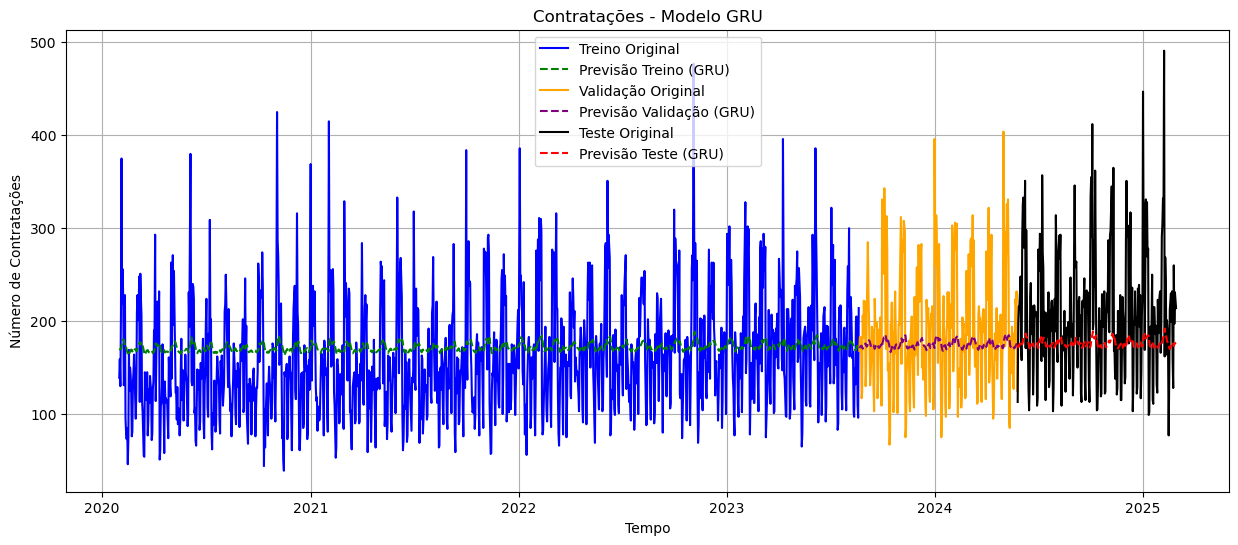

In [22]:
# Plot GRU
plt.figure(figsize=(15, 6))
plt.plot(train_idx, y_true_train_inv, label="Treino Original", color="blue", linestyle='-')
plt.plot(train_idx, y_pred_train_inv, label="Previsão Treino (GRU)", color="green", linestyle='--')
plt.plot(val_idx, y_true_val_inv, label="Validação Original", color="orange", linestyle='-')
plt.plot(val_idx, y_pred_val_inv, label="Previsão Validação (GRU)", color="purple", linestyle='--')
plt.plot(test_idx, y_true_test_inv, label="Teste Original", color="black", linestyle='-')
plt.plot(test_idx, y_pred_test_inv, label="Previsão Teste (GRU)", color="red", linestyle='--')
plt.title("Contratações - Modelo GRU")
plt.xlabel("Tempo")
plt.ylabel("Número de Contratações")
plt.legend()
plt.grid(True)
plt.show()

#### 5.3. LSTM MODEL

In [23]:
# LSTM architecture
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)])

In [24]:
# Compilation
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Callback para exibir a loss a cada 5 épocas
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}, Loss: {logs['loss']:.6f}, Val Loss: {logs['val_loss']:.6f}")
    if (epoch + 1) % 5 == 0 else None)

In [26]:
# LSTM training (with validation)
print("\nTraining LSTM model...\n")
model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=10,
    verbose=0,  
    callbacks=[callback])


Training LSTM model...

Epoch 5, Loss: 0.013927, Val Loss: 0.020576
Epoch 10, Loss: 0.011174, Val Loss: 0.014875
Epoch 15, Loss: 0.010468, Val Loss: 0.013013
Epoch 20, Loss: 0.010070, Val Loss: 0.013472
Epoch 25, Loss: 0.008920, Val Loss: 0.010385
Epoch 30, Loss: 0.007714, Val Loss: 0.009675


In [27]:
# Predictions
train_pred_lstm = model_lstm.predict(X_train)
val_pred_lstm = model_lstm.predict(X_val)
test_pred_lstm = model_lstm.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [28]:
# Inverse transform
train_pred_inv = scaler.inverse_transform(train_pred_lstm)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
val_pred_inv = scaler.inverse_transform(val_pred_lstm)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
test_pred_inv = scaler.inverse_transform(test_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [29]:
# Model metrics
print("\nResults with LSTM:")
rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
mdae_train = median_absolute_error(y_train_inv, train_pred_inv)
print(f"Treino - RMSE: {rmse_train:.2f} | MDAE: {mdae_train:.2f}")

rmse_val = np.sqrt(mean_squared_error(y_val_inv, val_pred_inv))
mdae_val = median_absolute_error(y_val_inv, val_pred_inv)
print(f"Validação - RMSE: {rmse_val:.2f} | MDAE: {mdae_val:.2f}")

rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
mdae_test = median_absolute_error(y_test_inv, test_pred_inv)
print(f"Teste - RMSE: {rmse_test:.2f} | MDAE: {mdae_test:.2f}")


Results with LSTM:
Treino - RMSE: 38.82 | MDAE: 21.31
Validação - RMSE: 44.46 | MDAE: 23.41
Teste - RMSE: 50.86 | MDAE: 26.43


In [30]:
# Adjust the indexes
train_idx = df.index[look_back:look_back + len(y_train_inv)]
val_idx = df.index[look_back + len(y_train_inv):look_back + len(y_train_inv) + len(y_val_inv)]
test_idx = df.index[look_back + len(y_train_inv) + len(y_val_inv):look_back + len(y_train_inv) + len(y_val_inv) + len(y_test_inv)]

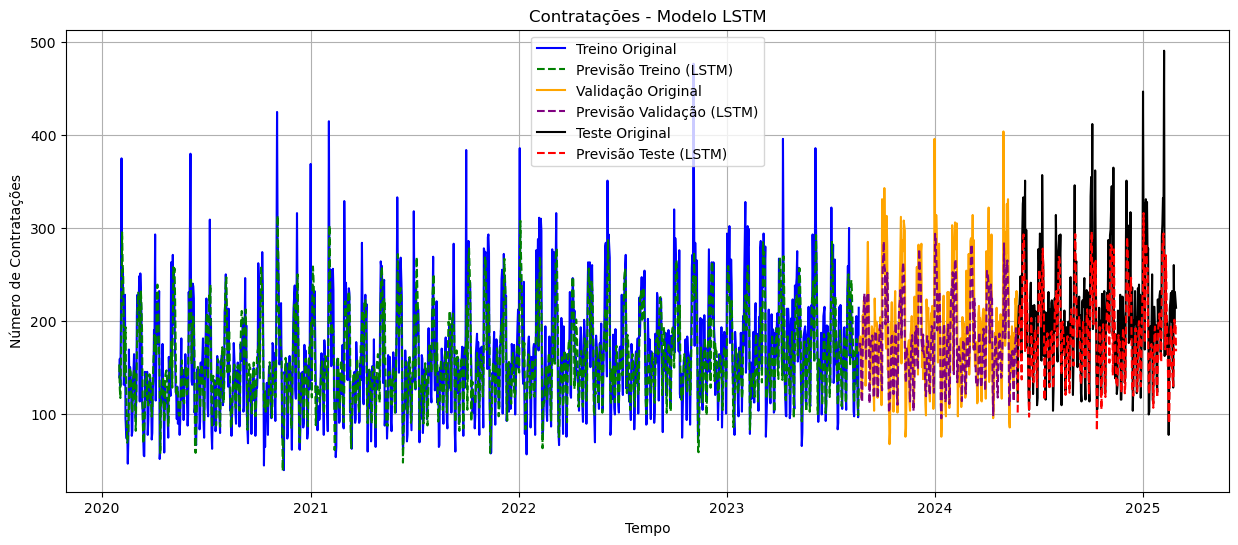

In [31]:
# Plot LSTM
plt.figure(figsize=(15, 6))
plt.plot(train_idx, y_train_inv, label="Treino Original", color="blue", linestyle='-')
plt.plot(train_idx, train_pred_inv, label="Previsão Treino (LSTM)", color="green", linestyle='--')
plt.plot(val_idx, y_val_inv, label="Validação Original", color="orange", linestyle='-')
plt.plot(val_idx, val_pred_inv, label="Previsão Validação (LSTM)", color="purple", linestyle='--')
plt.plot(test_idx, y_test_inv, label="Teste Original", color="black", linestyle='-')
plt.plot(test_idx, test_pred_inv, label="Previsão Teste (LSTM)", color="red", linestyle='--')
plt.title("Contratações - Modelo LSTM")
plt.xlabel("Tempo")
plt.ylabel("Número de Contratações")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# DataFrame for the test data
df_test_lstm = pd.DataFrame({
    'Real': y_test_inv.flatten(),
    'Predicted': test_pred_inv.flatten()}, index=test_idx)

In [33]:
# Calculate the percentage difference for the test data
df_test_lstm['Difference (%)'] = ((df_test_lstm['Predicted'] - df_test_lstm['Real']) / df_test_lstm['Real']) * 100
print("\nTest DataFrame (LSTM) with Percentage Difference:\n", df_test_lstm.head())


Test DataFrame (LSTM) with Percentage Difference:
              Real   Predicted  Difference (%)
data                                         
2024-05-26  113.0  101.079758      -10.548887
2024-05-27  199.0  152.743454      -23.244495
2024-05-28  216.0  191.817276      -11.195706
2024-05-29  217.0  206.960159       -4.626655
2024-05-30  230.0  216.045425       -6.067206


In [34]:
# Average percentage difference
average_percentage_difference = df_test_lstm['Difference (%)'].mean()
print(f"\nAverage Percentage Difference in the Test Set: {average_percentage_difference:.2f}%")


Average Percentage Difference in the Test Set: -7.38%


In [35]:
# Salve the file
df_test_lstm.to_csv(os.path.join("../data", "test_lstm_predictions.csv"), index=True)
print(f"\nDataFrame salvo com sucesso em: {os.path.join('../data', 'test_lstm_predictions.csv')}")


DataFrame salvo com sucesso em: ../data\test_lstm_predictions.csv


### 6. SAVE THE MODEL TO DISK
Dentre os modelos treinados, o LSTM apresentou o melhor desempenho nas métricas avaliadas, sendo, portanto, o modelo selecionado e que salvaremos em disco.

In [36]:
# Create directory
os.makedirs('../models', exist_ok=True)

# Save the LSTM model
model_lstm.save('../models/lstm_model.keras')

# Save the scaler
joblib.dump(scaler, '../models/scaler.gz')
print("Model and scaler saved successfully.")

Model and scaler saved successfully.


### END